**Название исследования:** Дипломный проект СФ Багдасарян Карен Овикович

**Цель:** Построить рекомендательную систему для магазина, в котором присутствует клубная система


Начинаем нашу работу с импорта библиотек. По мере выполнения проекта дописываем сюда необходимые библиотеки

In [1]:
import scipy.stats
import matplotlib

import pandas as pd
import numpy as np

import seaborn as sns

import datetime as dt

import scipy.sparse as sparse
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors  
from collections import defaultdict
from scipy.sparse import csr_matrix 
from sklearn.impute import SimpleImputer

from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})

Выведем установленные пакеты

In [2]:
pip list

Package                       Version
----------------------------- ---------------
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcal

Реализовываем загрузку данных, содержащихся в csv-файлах, а также проводим их первичное исследование методами head(), info(), shape

In [3]:
df_rating = pd.read_csv("transactions.csv", index_col=0)
df_rating.head()

,t_dat,article_id,price,customer_id
0,2020-04-13,706016003,33.88,0
1,2018-09-21,493810014,19.05,1
2,2018-10-04,594541012,16.93,2
3,2018-12-11,719712001,36.00,3
4,2019-04-08,700737007,25.41,4


In [4]:
df_user = pd.read_csv("customers.csv", index_col=0)
df_user.head()

,club_member,fashion_news,age,customer_id
0,ACTIVE,NONE,49.0,91991
1,ACTIVE,Regularly,32.0,164401
2,ACTIVE,Regularly,56.0,182738
3,ACTIVE,Regularly,30.0,166422
4,PRE-CREATE,Regularly,40.0,164557


In [5]:
df_rating.shape

(317884, 4)

In [6]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317884 entries, 0 to 317883
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   t_dat        317884 non-null  object 
 1   article_id   317884 non-null  int64  
 2   price        317884 non-null  float64
 3   customer_id  317884 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 12.1+ MB


In [7]:
df_item = pd.read_csv("product.csv", index_col=0)
df_item.head()

,article_id,product_name,color
0,108775015,Vest top,Black
1,108775044,Vest top,White
2,110065001,Bra,Black
3,110065002,Bra,White
4,110065011,Bra,Light Beige


In [8]:
df_user.shape

(229804, 4)

In [9]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229804 entries, 0 to 229803
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   club_member   229343 non-null  object 
 1   fashion_news  228565 non-null  object 
 2   age           228613 non-null  float64
 3   customer_id   229804 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.8+ MB


In [10]:
df_item.shape

(53626, 3)

In [11]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53626 entries, 0 to 53625
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_id    53626 non-null  int64 
 1   product_name  53626 non-null  object
 2   color         53626 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


Проверим данные на пропуски

In [12]:
df_rating.isnull().sum()

t_dat          0
article_id     0
price          0
customer_id    0
dtype: int64

In [13]:
df_user.isnull().sum()

club_member      461
fashion_news    1239
age             1191
customer_id        0
dtype: int64

In [14]:
df_item.isnull().sum()

article_id      0
product_name    0
color           0
dtype: int64

Заполним пропуски с помощью самых популярных значений

In [15]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_user["club_member"] = imputer.fit_transform(df_user["club_member"].values.reshape(-1,1))[:,0]
df_user["fashion_news"] = imputer.fit_transform(df_user["fashion_news"].values.reshape(-1,1))[:,0]
df_user["age"] = imputer.fit_transform(df_user["age"].values.reshape(-1,1))[:,0]

Снова проверим на пропуски таблицу, в которой они присутсвовали

In [16]:
df_user.isnull().sum()

club_member     0
fashion_news    0
age             0
customer_id     0
dtype: int64

Сменим тип данных 'Даты', для того чтобы у нас была бы возможность пользоваться функциями pandas, предназначенными для работы с датой

In [17]:
df_rating["t_dat"] = pd.to_datetime(df_rating["t_dat"])

In [18]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317884 entries, 0 to 317883
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   t_dat        317884 non-null  datetime64[ns]
 1   article_id   317884 non-null  int64         
 2   price        317884 non-null  float64       
 3   customer_id  317884 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 12.1 MB


Проверим данные на наличие дубликатов в датасетах customers и product

In [19]:
df_user.duplicated().sum()

0

In [20]:
df_item.duplicated().sum()

0

Выполним поиск аномалий в данных

In [21]:
df_rating.describe()

print('\033[1m' + 'Уникальные значения' + '\033[0m' + '\n')
for i in df_rating.columns.to_list():
    print('\033[91m' + 'Признак {} имеет {} следующих уникальных значений:'.format(i, len(df_rating[i].unique())) + '\033[0m')
    print(df_rating[i].unique())
    print('\033[1m' + '---------------------------------------------------------------------------------' + '\033[0m') 

Уникальные значения

Признак t_dat имеет 734 следующих уникальных значений:
['2020-04-13T00:00:00.000000000' '2018-09-21T00:00:00.000000000'
 '2018-10-04T00:00:00.000000000' '2018-12-11T00:00:00.000000000'
 '2019-04-08T00:00:00.000000000' '2019-03-31T00:00:00.000000000'
 '2019-01-28T00:00:00.000000000' '2019-10-06T00:00:00.000000000'
 '2020-07-04T00:00:00.000000000' '2020-03-31T00:00:00.000000000'
 '2018-10-23T00:00:00.000000000' '2019-02-26T00:00:00.000000000'
 '2020-09-03T00:00:00.000000000' '2018-10-29T00:00:00.000000000'
 '2020-07-11T00:00:00.000000000' '2020-09-17T00:00:00.000000000'
 '2019-06-19T00:00:00.000000000' '2019-07-09T00:00:00.000000000'
 '2019-07-01T00:00:00.000000000' '2019-02-27T00:00:00.000000000'
 '2018-10-07T00:00:00.000000000' '2019-01-06T00:00:00.000000000'
 '2020-03-02T00:00:00.000000000' '2020-01-02T00:00:00.000000000'
 '2020-08-23T00:00:00.000000000' '2018-11-13T00:00:00.000000000'
 '2020-05-19T00:00:00.000000000' '2020-07-17T00:00:00.000000000'
 '2019-08-30T0

In [22]:
df_user.describe()

print('\033[1m' + 'Уникальные значения' + '\033[0m' + '\n')
for i in df_user.columns.to_list():
    print('\033[91m' + 'Признак {} имеет {} следующих уникальных значений:'.format(i, len(df_user[i].unique())) +'\033[0m')
    print(df_user[i].unique())
    print('\033[1m' + '---------------------------------------------------------------------------------' + '\033[0m') 

Уникальные значения

Признак club_member имеет 3 следующих уникальных значений:
['ACTIVE' 'PRE-CREATE' 'LEFT CLUB']
---------------------------------------------------------------------------------
Признак fashion_news имеет 3 следующих уникальных значений:
['NONE' 'Regularly' 'Monthly']
---------------------------------------------------------------------------------
Признак age имеет 79 следующих уникальных значений:
[49. 32. 56. 30. 40. 44. 26. 24. 52. 48. 19. 51. 25. 20. 43. 41. 60. 45.
 28. 27. 71. 22. 36. 23. 34. 39. 50. 33. 29. 55. 42. 47. 53. 54. 46. 59.
 21. 61. 58. 62. 35. 68. 64. 63. 38. 57. 31. 65. 37. 66. 18. 72. 76. 70.
 75. 73. 67. 69. 74. 17. 78. 82. 79. 77. 85. 84. 88. 83. 80. 93. 81. 16.
 91. 89. 90. 98. 95. 87. 96.]
---------------------------------------------------------------------------------
Признак customer_id имеет 229804 следующих уникальных значений:
[ 91991 164401 182738 ...  76150  94386 210647]
-------------------------------------------------------------

In [23]:
df_item.describe()

print('\033[1m' + 'Уникальные значения' + '\033[0m' + '\n')
for i in df_item.columns.to_list():
    print('\033[91m' + 'Признак {} имеет {} следующих уникальных значений:'.format(i, len(df_item[i].unique())) + '\033[0m')
    print(df_item[i].unique())
    print('\033[1m' + '---------------------------------------------------------------------------------' + '\033[0m') 

Уникальные значения

Признак article_id имеет 53626 следующих уникальных значений:
[108775015 108775044 110065001 ... 949551002 952267001 953450001]
---------------------------------------------------------------------------------
Признак product_name имеет 118 следующих уникальных значений:
['Vest top' 'Bra' 'Underwear Tights' 'Leggings/Tights' 'Trousers'
 'Hair clip' 'Umbrella' 'Sweater' 'Bodysuit' 'Hair string' 'Socks'
 'Unknown' 'Top' 'Pyjama jumpsuit/playsuit' 'Hoodie' 'Hair/alice band'
 'Belt' 'Bikini top' 'Underwear bottom' 'Swimsuit' 'Skirt' 'Hat/beanie'
 'Kids Underwear top' 'Shorts' 'T-shirt' 'Cap/peaked' 'Pyjama set'
 'Sneakers' 'Dress' 'Sunglasses' 'Cardigan' 'Gloves' 'Earring' 'Blazer'
 'Swimwear bottom' 'Jacket' 'Shirt' 'Costumes' 'Robe' 'Scarf' 'Coat'
 'Other accessories' 'Polo shirt' 'Slippers' 'Night gown' 'Alice band'
 'Straw hat' 'Tailored Waistcoat' 'Ballerinas' 'Tie' 'Necklace'
 'Pyjama bottom' 'Felt hat' 'Bag' 'Bracelet' 'Boots' 'Blouse' 'Watch'
 'Beanie' 'Hat/bri

Построим диаграмму размаха по признаку возраст покупателя и выполним удаление выбросов

<Axes: >

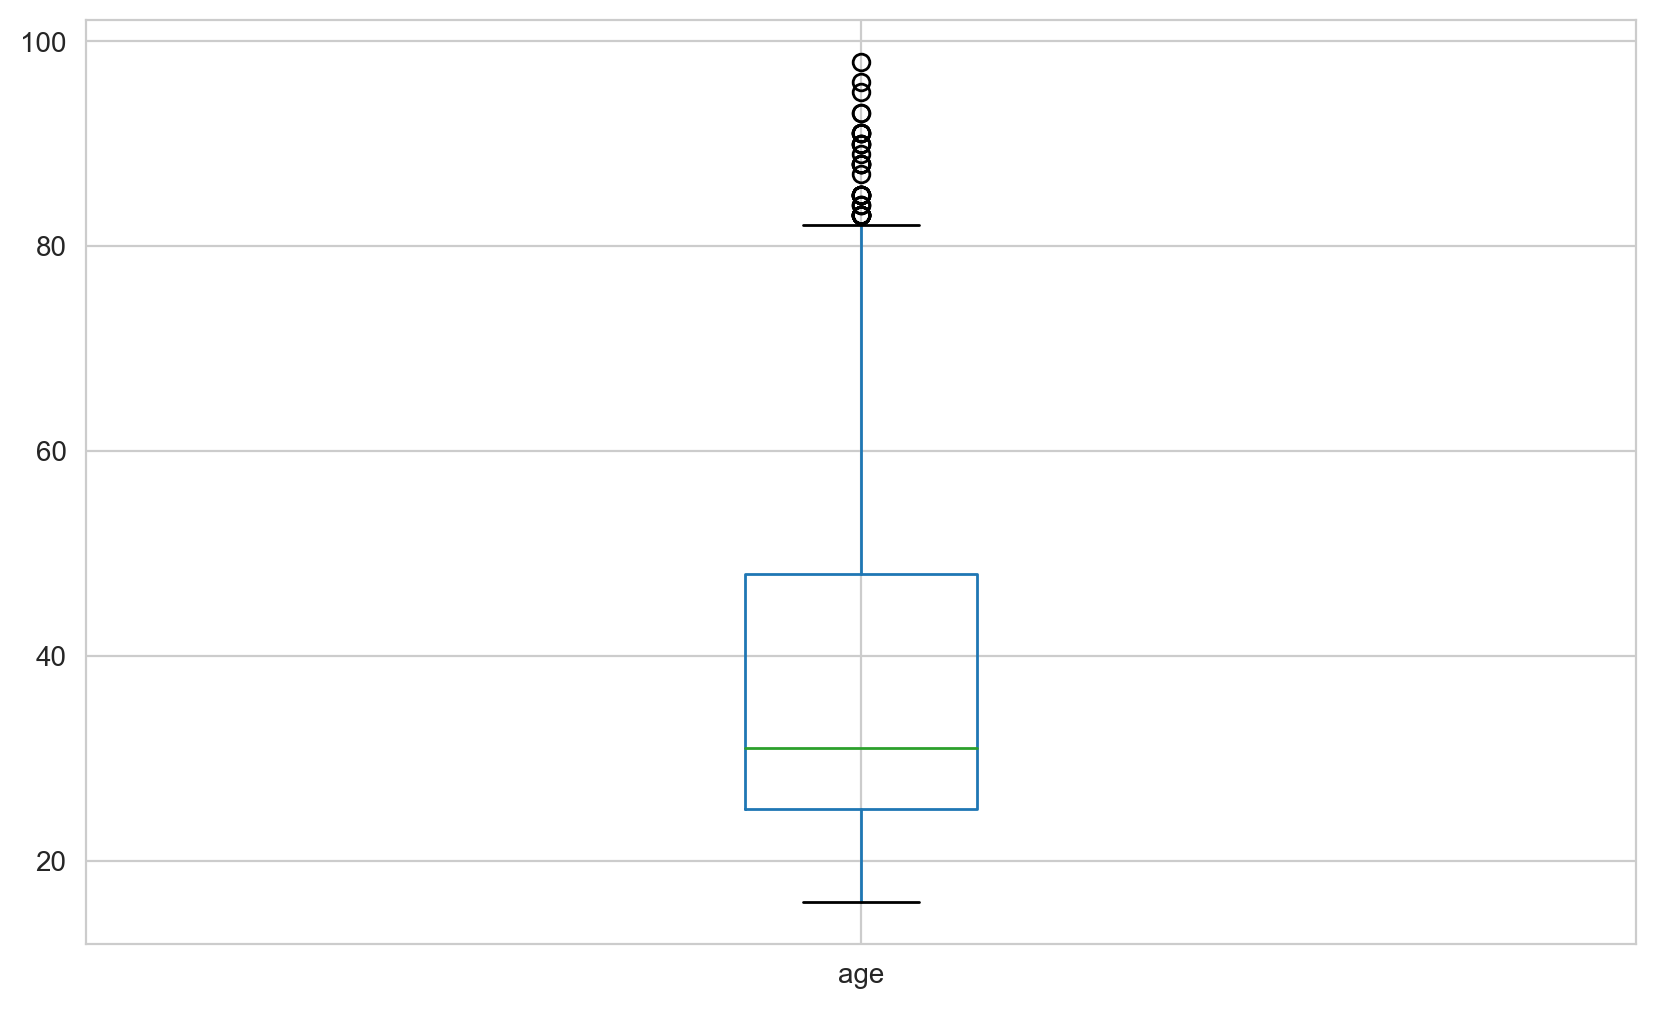

In [24]:
df_user.boxplot(column = ['age'])

In [25]:
df_user1 = df_user[df_user['age'] < 80]
df_user1

,club_member,fashion_news,age,customer_id
0,ACTIVE,NONE,49.0,91991
1,ACTIVE,Regularly,32.0,164401
2,ACTIVE,Regularly,56.0,182738
3,ACTIVE,Regularly,30.0,166422
4,PRE-CREATE,Regularly,40.0,164557
...,...,...,...,...
229799,ACTIVE,Regularly,44.0,96272
229800,ACTIVE,NONE,27.0,14468
229801,ACTIVE,NONE,27.0,76150
229802,ACTIVE,NONE,40.0,94386


Определим сколько товаров продавалось в разные месяцы и построим график плотности

In [26]:
df_rating['Месяц'] = df_rating.t_dat.dt.month.values
df_temp = df_rating.groupby("Месяц")["article_id"].count() \
.rename('Количество товаров').reset_index()
df_temp

,Месяц,Количество товаров
0,1,23165
1,2,21674
2,3,23267
3,4,28219
4,5,29381
5,6,36848
6,7,31698
7,8,24846
8,9,26160
9,10,25427


<Axes: ylabel='Density'>

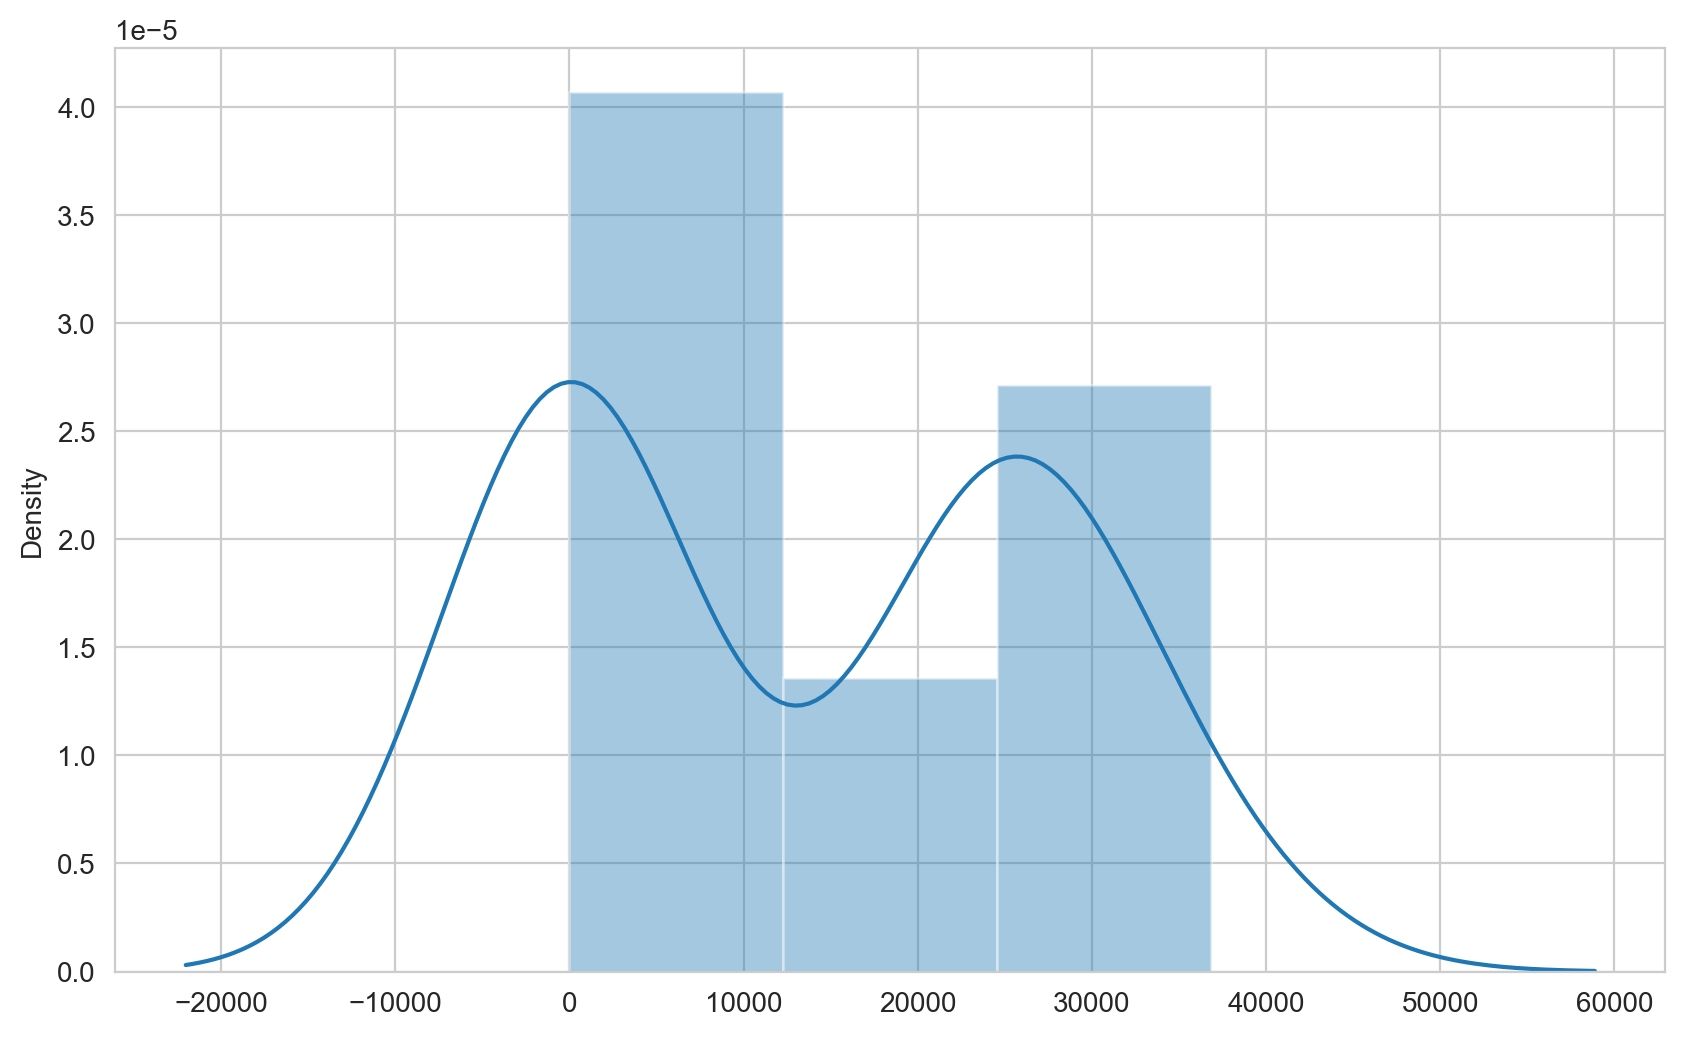

In [27]:
sns.distplot(df_temp)

Определим список товаров ТОП-10 с максимальной выручкой за все время и построим столбчатую диаграмму

In [28]:
df_prices = df_rating[["price","article_id"]].groupby("article_id").sum().sort_values(by="price", ascending=False) \
            .rename(columns={"price":"выручка"}) \
            .reset_index()
df_prices = df_prices.merge(df_item, how='left', left_on='article_id', right_on='article_id') \
            .sort_values(['выручка'],ascending=False)
df_prices.head(10)

,article_id,выручка,product_name,color
0,706016001,16364.05,Trousers,Black
1,706016002,11309.68,Trousers,Light Blue
2,568601006,9659.58,Blazer,Black
3,448509014,7720.95,Trousers,Blue
4,706016003,7001.72,Trousers,Dark Blue
5,562245046,6886.59,Trousers,Black
6,661794001,6848.58,Coat,Light Beige
7,399223001,6772.23,Trousers,Black
8,720125001,6312.63,Leggings/Tights,Black
9,562245001,5761.51,Trousers,Black


In [29]:
top_ten = 10
df_prices = df_prices[:top_ten]

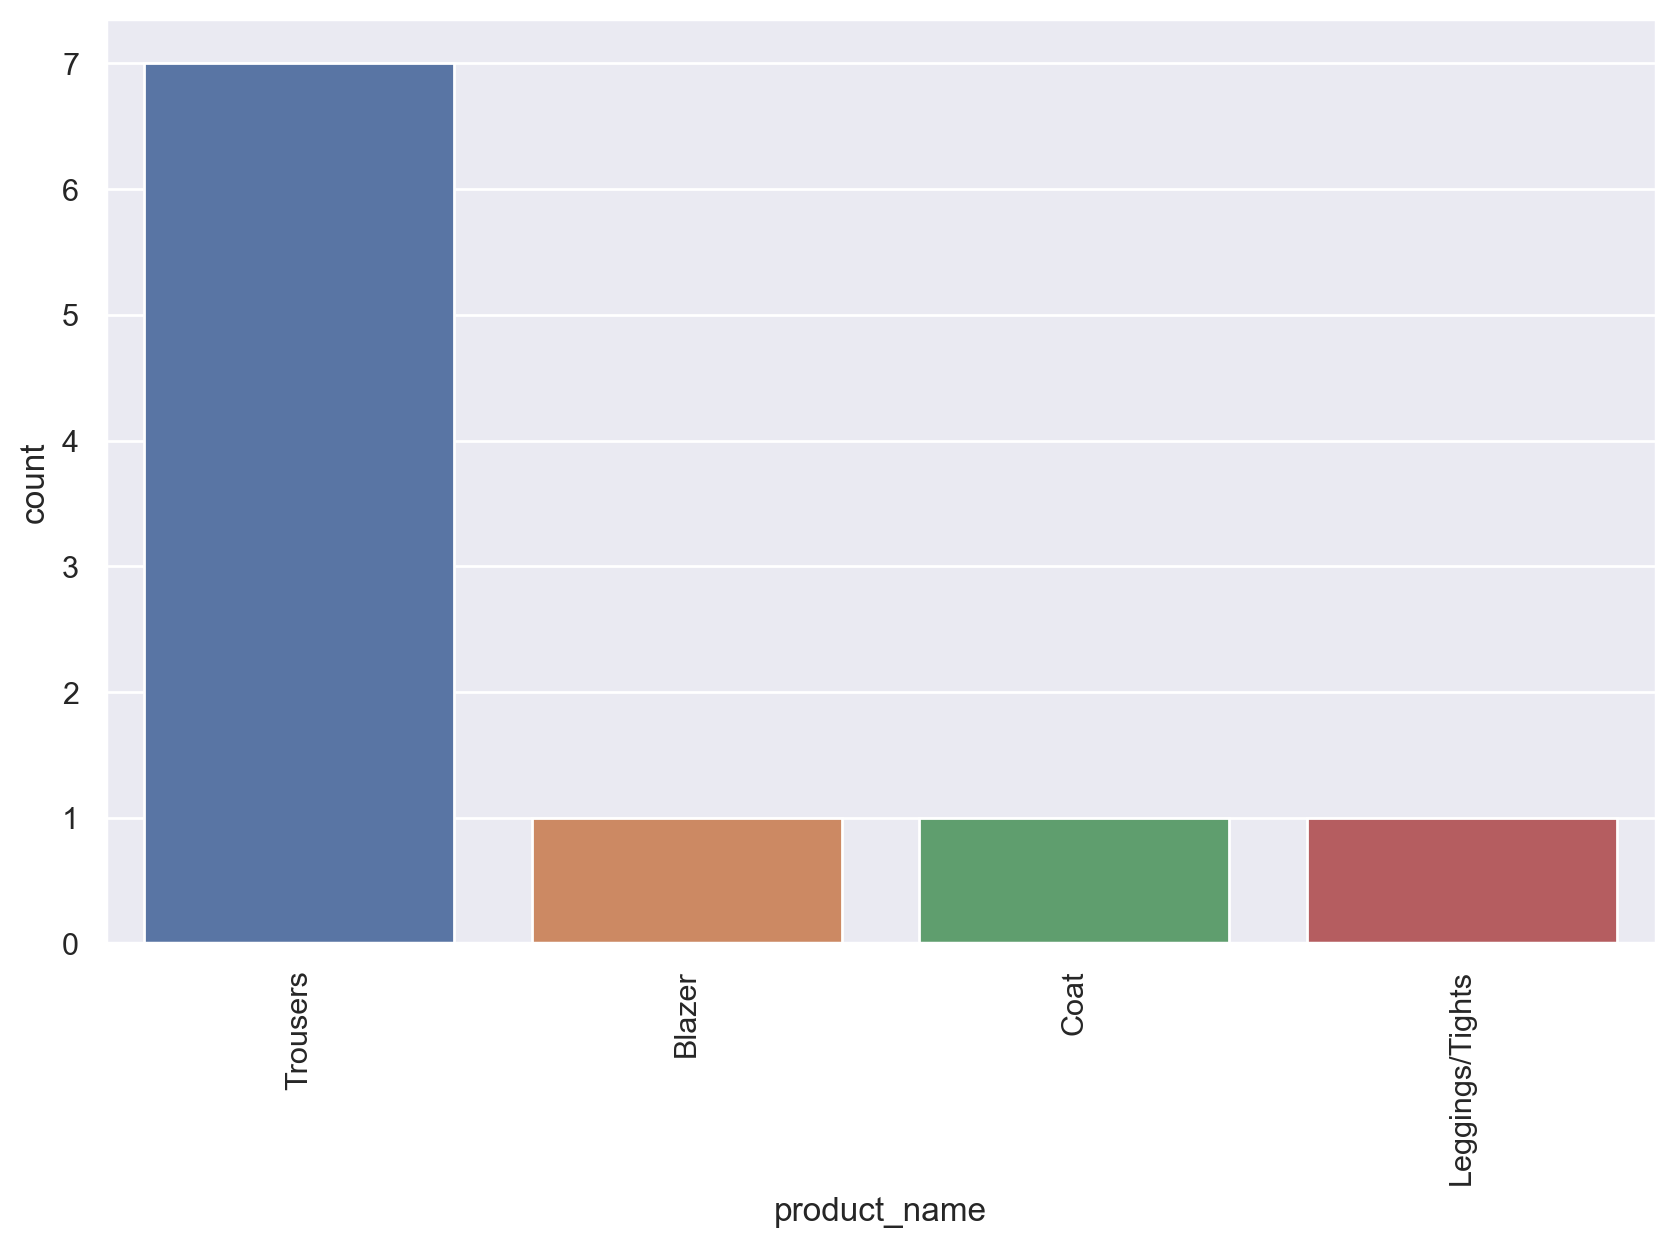

In [30]:
sns.set()
ax = sns.countplot(x = "product_name", data = df_prices)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

Определим список популярных товаров ТОП-10 за все время, построим столбчатую диаграмму

In [31]:
df_items_all_time=df_rating.merge(df_item).groupby("product_name").sum()
df_items_all_time.head(10)

,article_id,price,customer_id,Месяц
product_name,,,,
Accessories set,2471968010,47.75,176677,26
Alice band,4889732009,62.92,1186346,81
Backpack,19150363149,874.43,2107583,186
Bag,1509222095168,62269.82,224270094,14008
Ballerinas,290065196630,9563.78,51090524,3249
Beanie,34025523291,684.68,4879593,382
Belt,1255851672037,33031.08,207189401,13192
Bikini top,8144061789487,262891.50,1208813448,62581
Blazer,3259054044108,240276.84,457199402,29402


In [32]:
top_ten_all_time = 10
df_items_all_time = df_items_all_time[:top_ten]

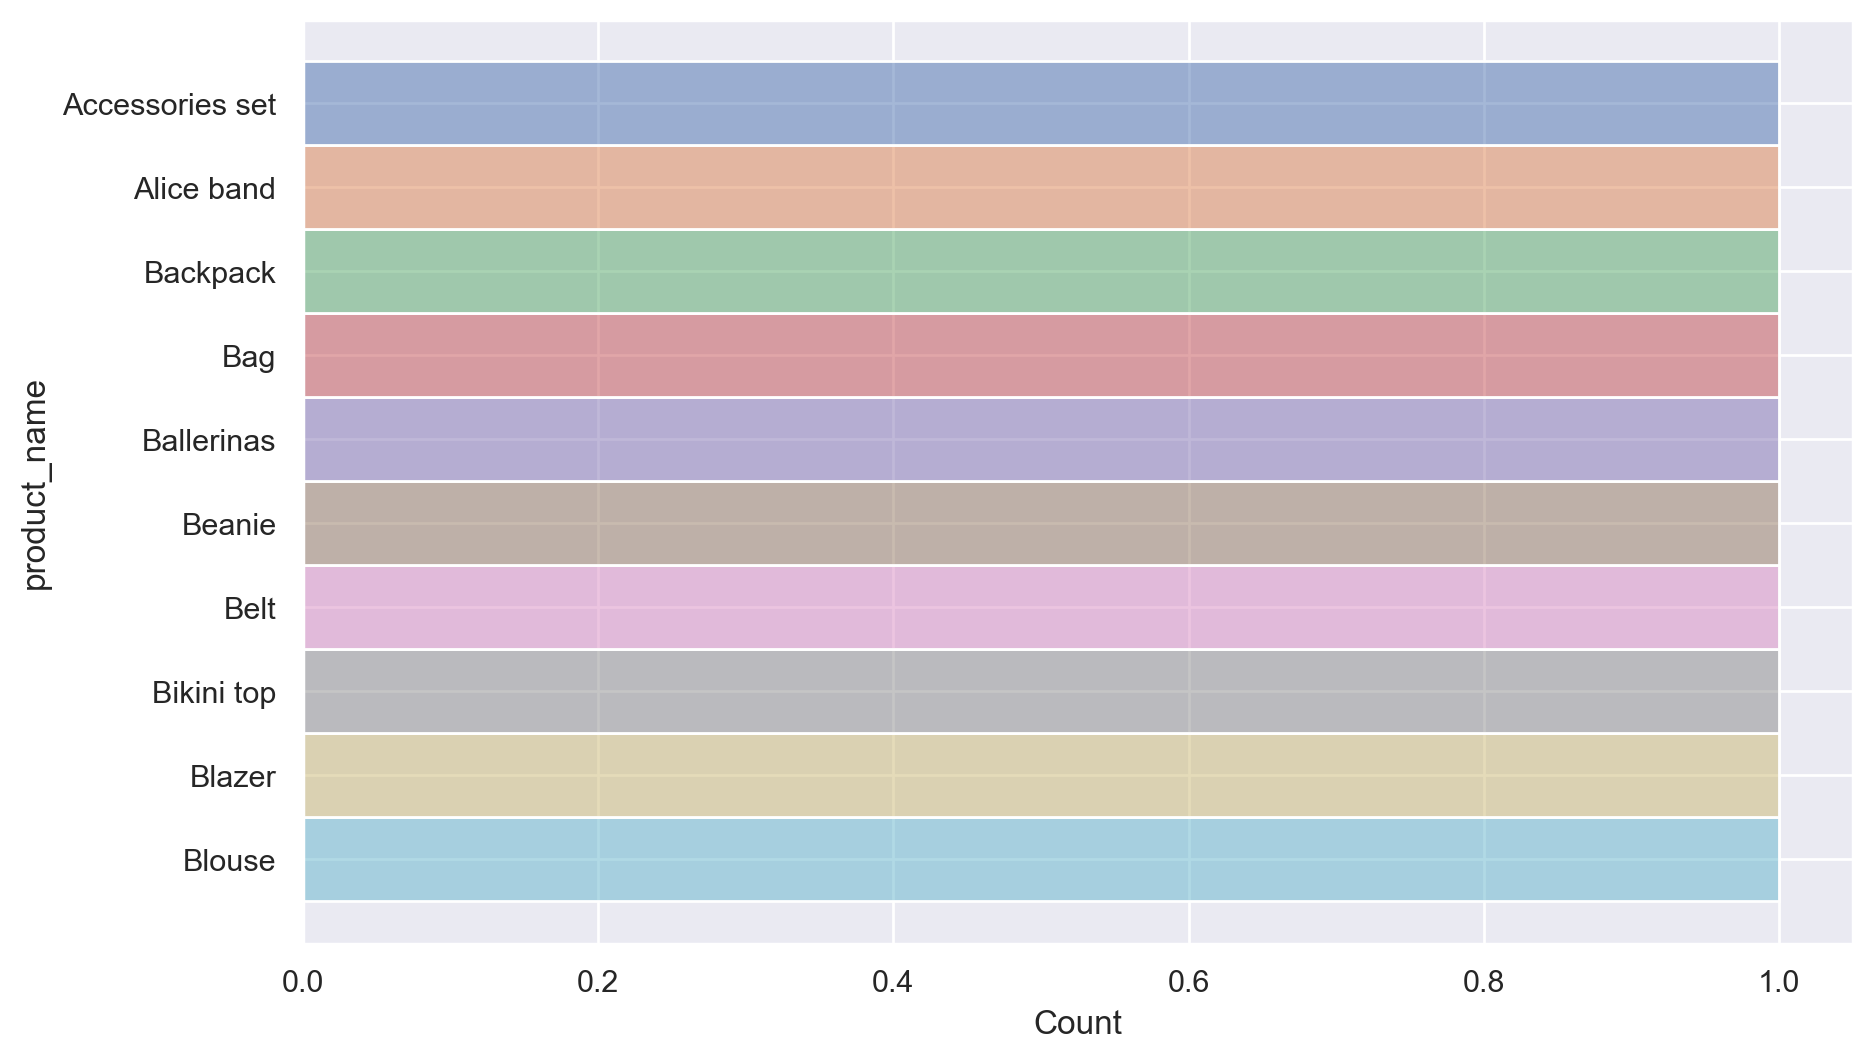

In [33]:
sns.histplot(y = 'product_name', hue = 'product_name', data = df_items_all_time, legend = False);

Определим долю товаров, которые были проданы один раз, построим круговую диаграмму

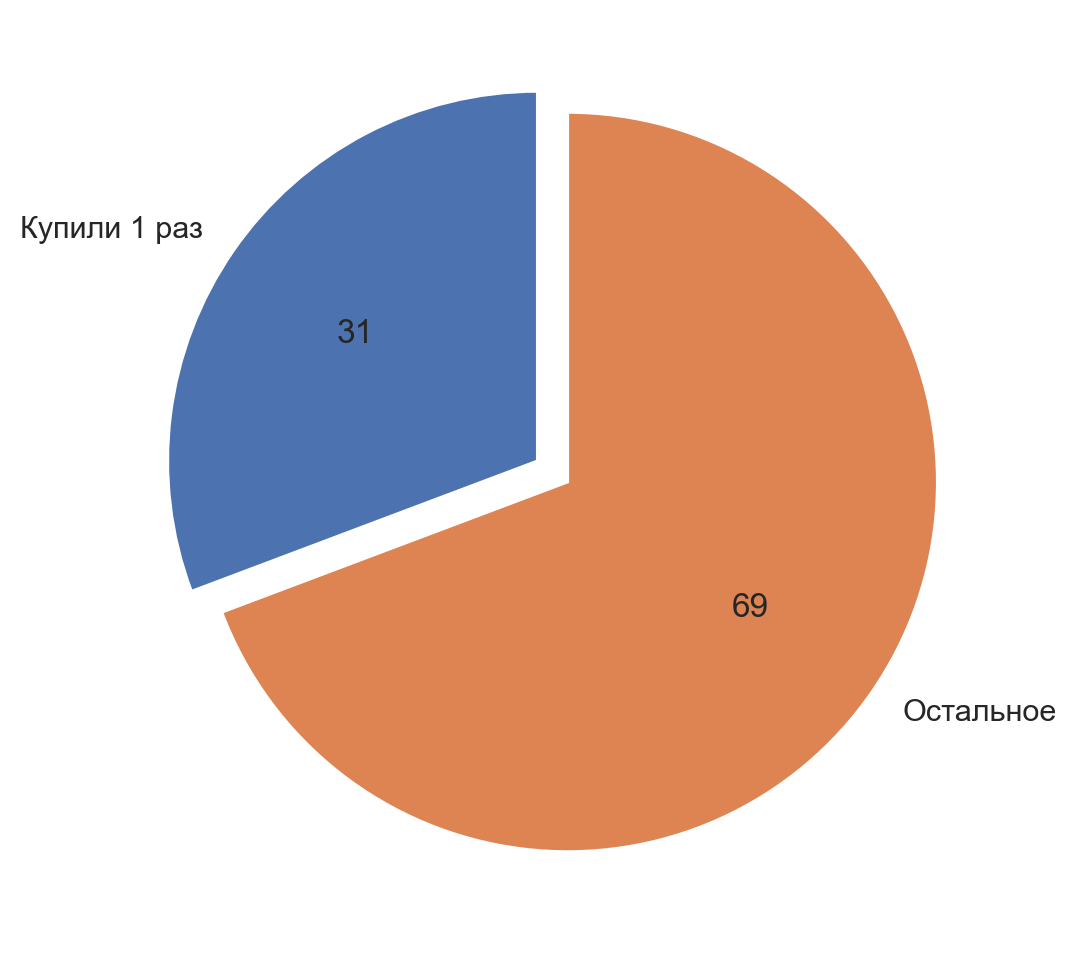

In [34]:
df_sold_qty = df_rating["article_id"].value_counts().reset_index() \
            .rename(columns = {"article_id":"sold_qty","index":"article_id"})

df_temp = [df_sold_qty["sold_qty"].where(lambda x: x==1).count(), df_sold_qty["sold_qty"].where(lambda x: x>1).count()]
labels = 'Купили 1 раз', 'Остальное'
plt.pie(df_temp, autopct='%.0f', explode=(0.1, 0), labels=labels, startangle=90);

Определим какая возрастная группа покупает больше товаров, группы сформируем с шагом 10 лет, построим столбчатую диаграмму и график плотности распределения

In [35]:
df_cust_qty = df_rating["customer_id"].value_counts().reset_index() \
            .rename(columns = {"customer_id":"sold_qty","index":"customer_id"})
df_cust_qty = df_cust_qty.merge(df_user, how='left', left_on='customer_id', right_on='customer_id') \
            .sort_values(['sold_qty'],ascending=False)
df_cust_qty

,customer_id,sold_qty,club_member,fashion_news,age
0,23883,21,ACTIVE,Regularly,61.0
2,7232,19,ACTIVE,Regularly,54.0
1,2458,19,ACTIVE,NONE,31.0
3,5919,17,ACTIVE,Regularly,28.0
4,18097,16,ACTIVE,NONE,43.0
...,...,...,...,...,...
115089,198576,1,ACTIVE,NONE,61.0
115090,205582,1,ACTIVE,Regularly,61.0
115091,205581,1,ACTIVE,Regularly,23.0
115092,198577,1,ACTIVE,NONE,22.0


In [36]:
df_cust_qty['age_groups'] = pd.cut(df_cust_qty['age'], bins=[16, 20, 30, 40,50, 60, 70, float('Inf')], labels=['16-20', '20-30','30-40','40-50','50-60','60-70' , '70+'])
df_cust_qty

,customer_id,sold_qty,club_member,fashion_news,age,age_groups
0,23883,21,ACTIVE,Regularly,61.0,60-70
2,7232,19,ACTIVE,Regularly,54.0,50-60
1,2458,19,ACTIVE,NONE,31.0,30-40
3,5919,17,ACTIVE,Regularly,28.0,20-30
4,18097,16,ACTIVE,NONE,43.0,40-50
...,...,...,...,...,...,...
115089,198576,1,ACTIVE,NONE,61.0,60-70
115090,205582,1,ACTIVE,Regularly,61.0,60-70
115091,205581,1,ACTIVE,Regularly,23.0,20-30
115092,198577,1,ACTIVE,NONE,22.0,20-30


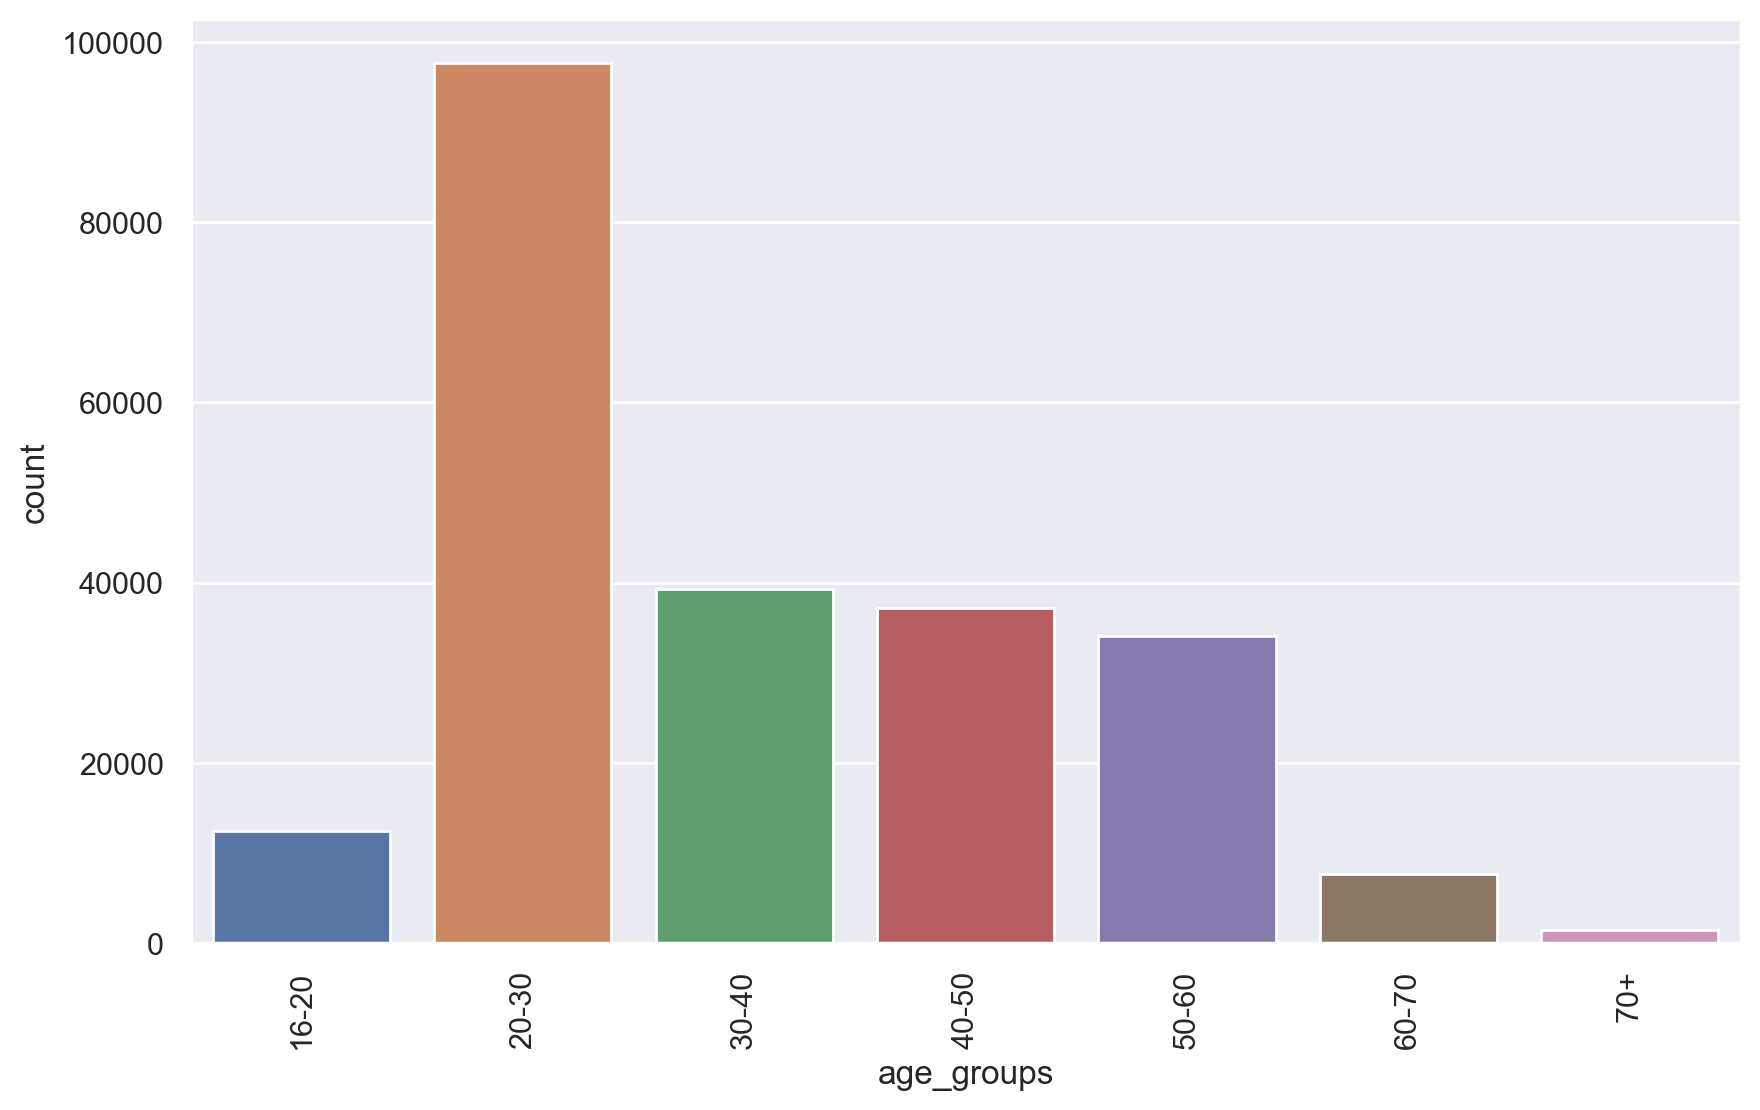

In [37]:
sns.set()
ax = sns.countplot(x = "age_groups", data = df_cust_qty)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

<Axes: xlabel='age_groups'>

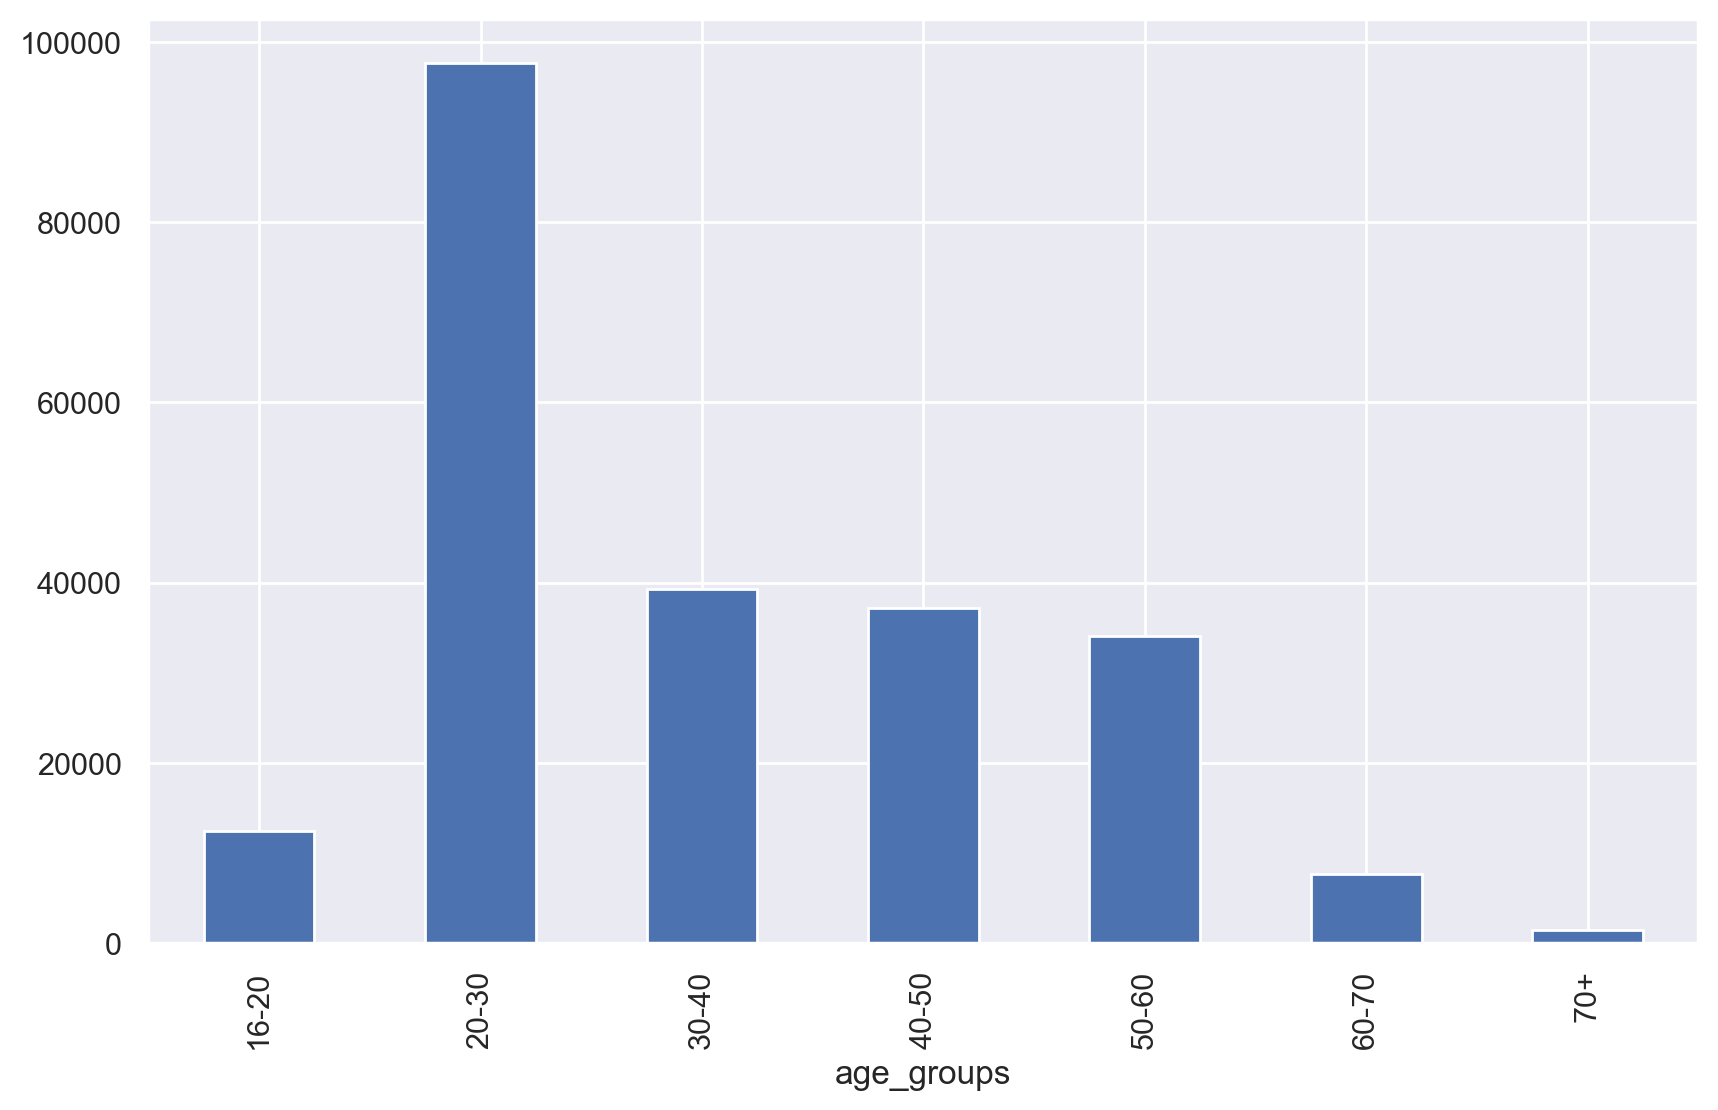

In [38]:
df_cust_qty.groupby('age_groups').size().plot(kind='bar')

Определим покупают ли больше товаров те, кто активно следит за новостями о моде, построить стобчатую диаграмму

In [39]:
df_temp = df_cust_qty.groupby("fashion_news")["customer_id"].sum() \
.transform(lambda x: (x / x.sum() * 100)).rename('Процент покупок').reset_index()

<Axes: xlabel='fashion_news', ylabel='Процент покупок'>

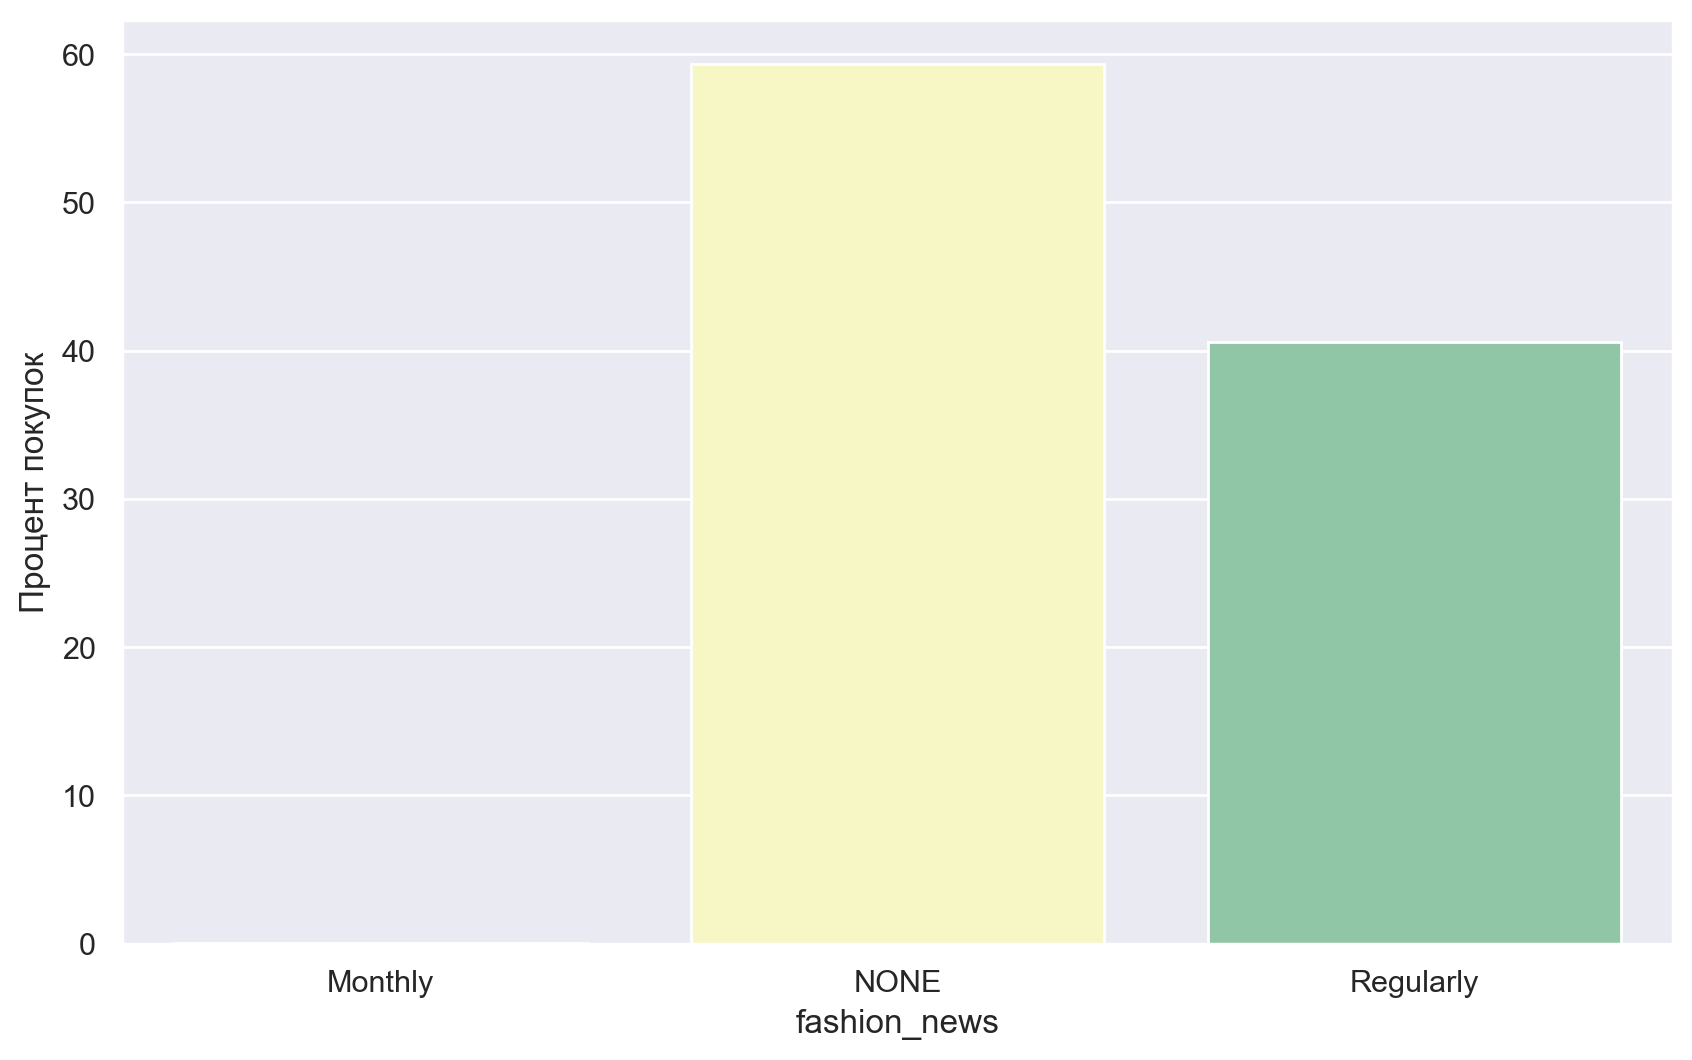

In [40]:
sns.barplot(x="fashion_news", y="Процент покупок", data=df_temp, palette="Spectral")

Проверим гипотезу о данных - влияет ли статус членства клуба на количество купленных товаров, найдем p-value, сформулируем вывод


In [41]:
df_cust_qty = df_rating["customer_id"].value_counts().reset_index() \
            .rename(columns = {"customer_id":"sold_qty","index":"customer_id"})
df_cust_qty = df_cust_qty.merge(df_user, how='left', left_on='customer_id', right_on='customer_id') \
            .sort_values(['sold_qty'],ascending=False)
df_cust_qty['fashion_news'] = df_cust_qty['fashion_news'].replace({'Regularly':2, 'NONE': 0, 'Monthly':1})
df_cust_qty['club_member'] = df_cust_qty['club_member'].replace({'ACTIVE':2, 'PRE-CREATE': 1, 'LEFT CLUB':0})

In [42]:
tt = pd.crosstab(df_cust_qty.club_member, df_cust_qty.sold_qty)

from scipy.stats import chi2_contingency
corr = chi2_contingency(tt) 

print('p-value = %.2f,  отвергаем нулевую гипотезу, связь есть' % corr[1])  

p-value = 0.00,  отвергаем нулевую гипотезу, связь есть


Вывод: Статус членства в клубе влияет на количество купленных товаров

Сформируем датасет с признаками покупатель, количество купленных товаров, возраст, итоговая потраченная сумма, членство в клубе, частота просмотра новостей

In [43]:
df_prices = df_rating[["price","customer_id"]].groupby("customer_id").sum().sort_values(by="price", ascending=False) \
            .rename(columns={"price":"выручка"}) \
            .reset_index()
df_cust_qty = df_rating["customer_id"].value_counts().reset_index() \
            .rename(columns = {"customer_id":"sold_qty","index":"customer_id"})
df_cust_qty = df_cust_qty.merge(df_prices, how='left', left_on='customer_id', right_on='customer_id')
df_cust_qty = df_cust_qty.merge(df_user, how='left', left_on='customer_id', right_on='customer_id') \
            .sort_values(['sold_qty'],ascending=False)
df_cust_qty['fashion_news'] = df_cust_qty['fashion_news'].replace({'Regularly':2, 'NONE': 0, 'Monthly':1})
df_cust_qty['club_member'] = df_cust_qty['club_member'].replace({'ACTIVE':2, 'PRE-CREATE': 1, 'LEFT CLUB':0})
df_cust_qty

,customer_id,sold_qty,выручка,club_member,fashion_news,age
0,23883,21,935.43,2,2,61.0
2,7232,19,610.12,2,2,54.0
1,2458,19,662.06,2,0,31.0
3,5919,17,771.61,2,2,28.0
4,18097,16,521.77,2,0,43.0
...,...,...,...,...,...,...
115089,198576,1,10.15,2,0,61.0
115090,205582,1,50.83,2,2,61.0
115091,205581,1,42.36,2,2,23.0
115092,198577,1,33.88,2,0,22.0


Найдем оптимальное количество кластеров по покупателям

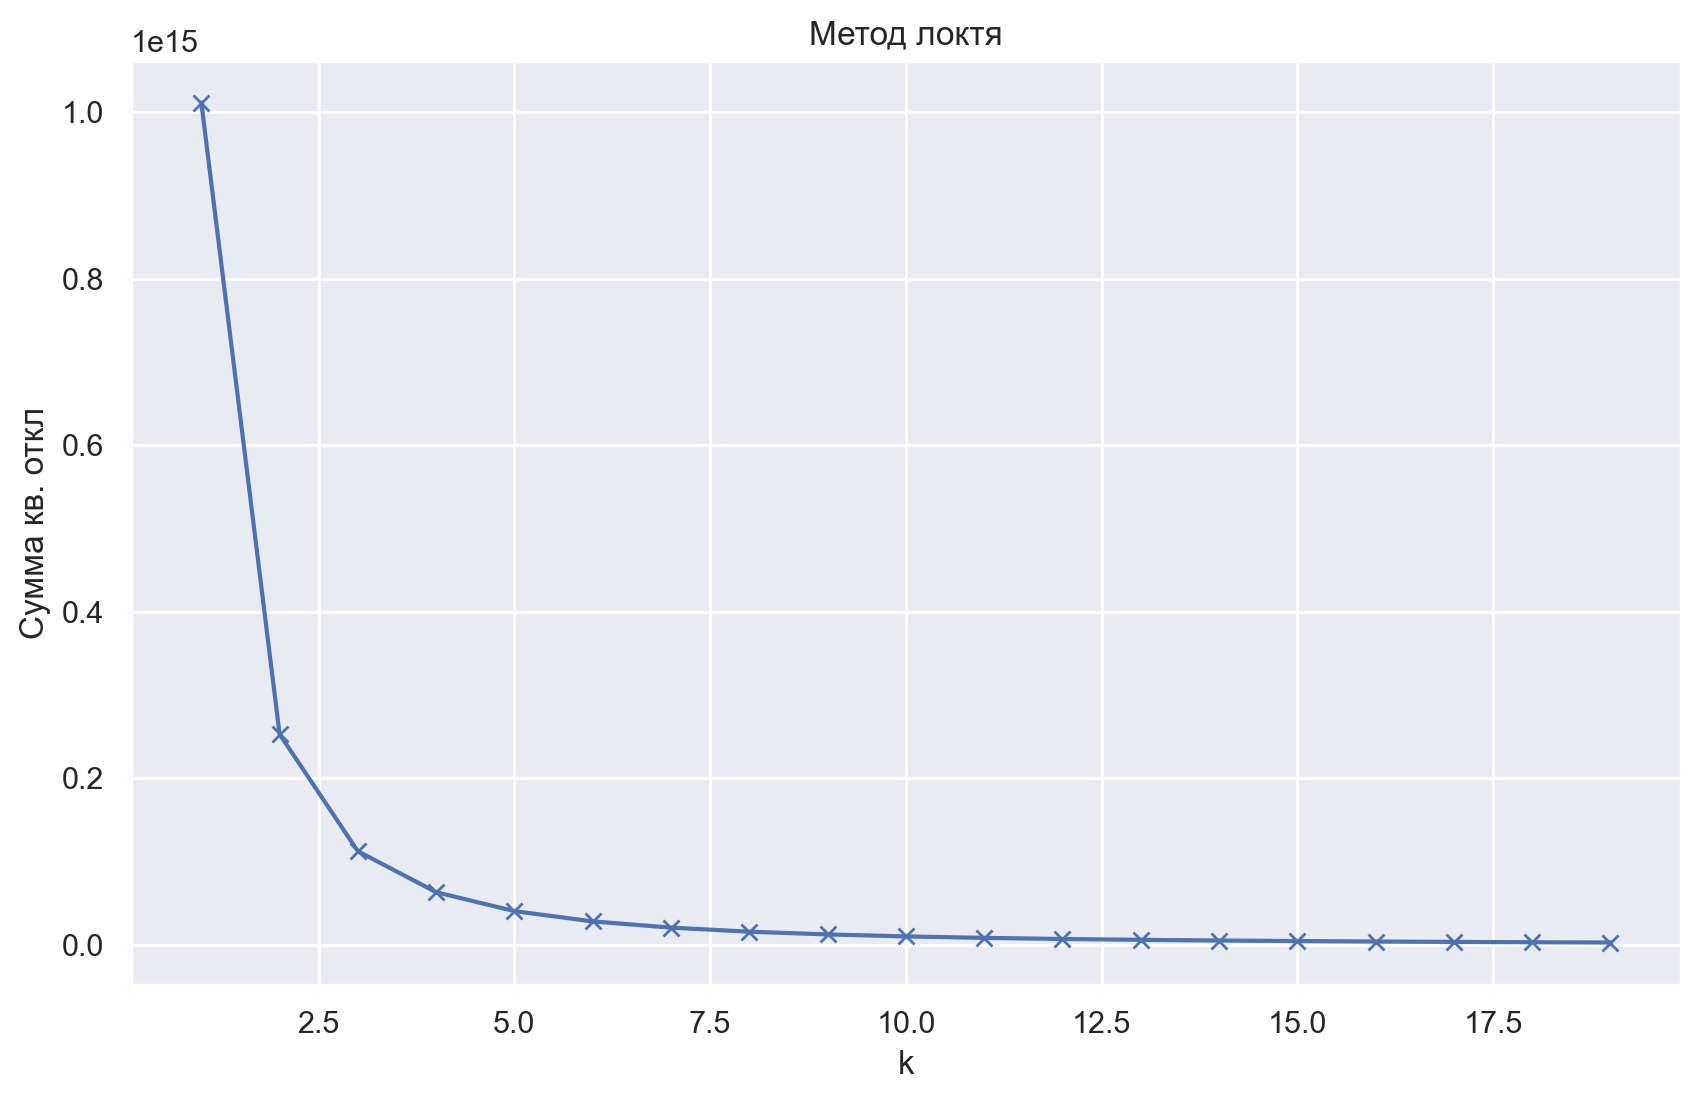

In [44]:
Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_cust_qty)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Сумма кв. откл')
plt.title('Метод локтя')
plt.show()

Построим модель кластеризации данных.   
Визуализируем кластеры с помощью диаграммы рассеивания, выберем подходящие признаки для диаграммы

In [45]:
kmeans = KMeans(n_clusters = 4, random_state=0).fit(df_cust_qty[['sold_qty', 'выручка', 'club_member', 'fashion_news', 'age']])
predict = kmeans.predict(df_cust_qty[['sold_qty', 'выручка', 'club_member', 'fashion_news', 'age']])
df_cust_qty['Кластер'] = predict
df_cust_qty.head()

,customer_id,sold_qty,выручка,club_member,fashion_news,age,Кластер
0,23883,21,935.43,2,2,61.0,2
2,7232,19,610.12,2,2,54.0,2
1,2458,19,662.06,2,0,31.0,2
3,5919,17,771.61,2,2,28.0,2
4,18097,16,521.77,2,0,43.0,2


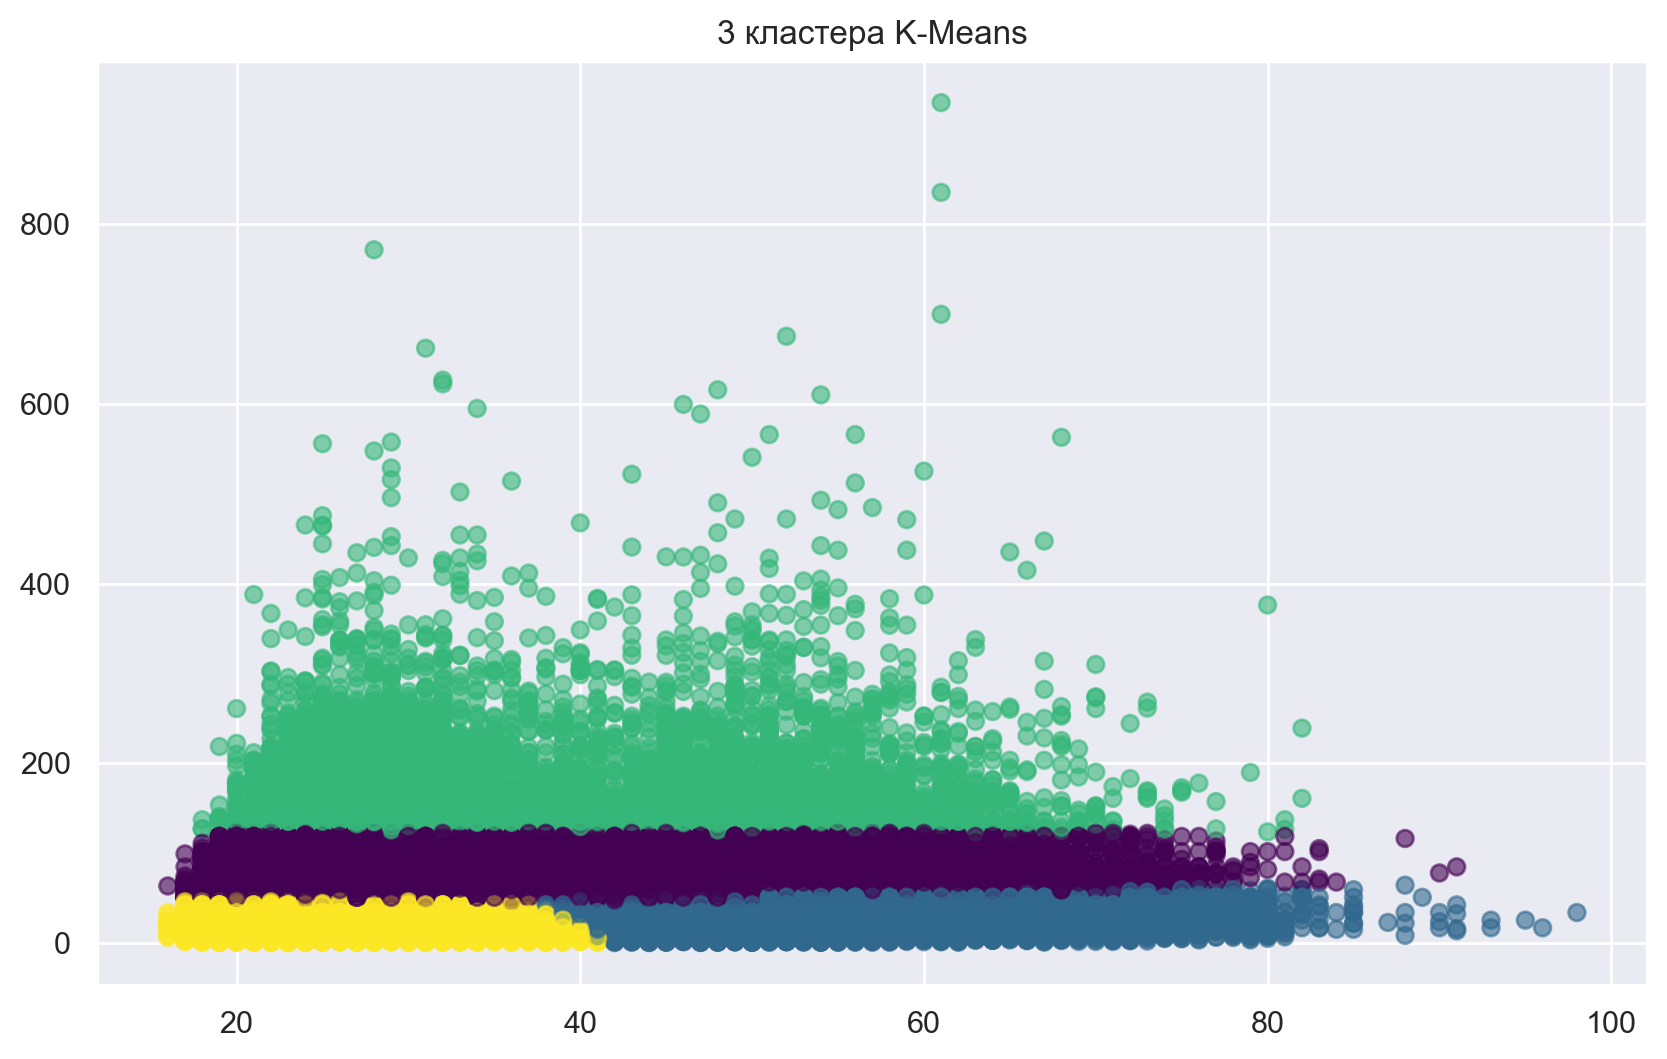

In [46]:
plt.scatter(df_cust_qty['age'], df_cust_qty["выручка"], c = kmeans.labels_, cmap='viridis', alpha = 0.6)
plt.title('3 кластера K-Means');

Сформируем датасет с признаками: покупатель, товар, количество купленных товаров

In [47]:
df = df_rating[["customer_id","article_id"]].value_counts().reset_index() \
            .rename(columns = {0:"sold_qty"})
df

,customer_id,article_id,sold_qty
0,37865,678342001,5
1,39574,507909001,4
2,26097,189634001,3
3,25061,684209012,3
4,65998,694966001,3
...,...,...,...
317136,62083,717664001,1
317137,62083,610776002,1
317138,62083,578476001,1
317139,62082,715343007,1


In [48]:
df.columns = ['user','item','rating']
df = df.iloc[:20000]
df

,user,item,rating
0,37865,678342001,5
1,39574,507909001,4
2,26097,189634001,3
3,25061,684209012,3
4,65998,694966001,3
...,...,...,...
19995,131736,757286005,1
19996,131726,833493002,1
19997,131736,751994009,1
19998,131736,705734001,1


Выполним коллаборативную фильтрацию по схожести покупателей

In [49]:
df_matrix = df.pivot(index= 'user',columns='item',values='rating').fillna(0)
w1_pivot_matrix = csr_matrix(df_matrix)


knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(w1_pivot_matrix)

def most_similar_users_to(user_id):
    most_similar_users_to = []
    distance, indice = model_knn.kneighbors(df_matrix.iloc[user_id,:].values.reshape(1,-1), n_neighbors=10)
    for i in range(1, len(distance.flatten())):
        user_id1 = df_matrix.index[indice.flatten()[i]]
        most_similar_users_to.append((user_id1, distance.flatten()[i]))

    most_similar_users_to.sort(key=lambda x: x[1], reverse=True)

    return most_similar_users_to[:10] 

In [50]:
def user_based_suggestions(user_id):
    suggestions = defaultdict(float)
    non_interacted_items = df_matrix.iloc[user_id][df_matrix.iloc[user_id]==0].index.tolist()
    for other_user_id, similarity in most_similar_users_to(user_id):
        items_user_id = df_matrix.loc[other_user_id][df_matrix.loc[other_user_id]>0]
        for interest in items_user_id.index.tolist():
            if interest in non_interacted_items:
                item_name = df_item[df_item['article_id']==interest]['product_name'].values[0]
                suggestions[item_name] += similarity
    suggestions = sorted(suggestions.items(),
                         key=lambda x: x[1],
                         reverse=True)
    return suggestions[:10] 

Выведем в качестве рекомендаций список наименований товаров для пользователя с ИД = 6510

In [51]:
print("Рекомендации для пользователя")
print(user_based_suggestions(6510))

Рекомендации для пользователя
[('T-shirt', 2.0), ('Underwear bottom', 2.0), ('Trousers', 1.0), ('Underwear Tights', 1.0), ('Dungarees', 1.0), ('Bikini top', 1.0), ('Dress', 1.0)]
